In [1]:
import numpy as np

from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import pickle



ModuleNotFoundError: No module named 'sklearn'

importation de la base de donné MNIST

In [2]:
import gzip
f = gzip.open('base_de_donnee/train-images-idx3-ubyte.gz','r')
image_size = 28
num_images = (60000, 0)  #nombre d'image pour l'entrainemnt puis pour les tests

f.read(16)
buf = f.read(image_size * image_size * sum(num_images))
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(sum(num_images), image_size, image_size, 1)

g = gzip.open('base_de_donnee/train-labels-idx1-ubyte.gz','r')
g.read(8)

liste_pour_x = []
liste_pour_y = []
for i in range(0,num_images[0]):   
    buf = g.read(1)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int8)
    a = np.array([0 for k in range(10)])
    a[labels] = 1 
    liste_pour_y.append(a)
    
    image = np.asarray(data[i]).squeeze()
    liste_pour_x.append(image.flatten())

liste_pour_x_test = []
liste_pour_y_test = []
for k in range(num_images[0],num_images[0] + num_images[1]):
    buf = g.read(1)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int8)
    a = np.array([0 for j in range(10)])
    a[labels] = 1 
    liste_pour_y_test.append(a)
    
    image = np.asarray(data[k]).squeeze()
    liste_pour_x_test.append(image.flatten())

In [4]:
X = np.array(liste_pour_x).T
y = np.array(liste_pour_y).T
X_test = np.array(liste_pour_x_test).T
y_test = np.array(liste_pour_y_test).T

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
class reseau_de_neurone:
    def __init__(self,dimensions,learning_rate):
        self.dimensions = dimensions
        self.parametres = self.initialisation()
        self.nombre_de_couche = len(self.parametres) // 2
        self.learning_rate = learning_rate

    def initialisation(self):
        parametres = {}
        C = len(self.dimensions)
        for c in range(1, C):
            parametres['W' + str(c)] = np.random.randn(self.dimensions[c], self.dimensions[c - 1])
            parametres['b' + str(c)] = np.random.randn(self.dimensions[c], 1)
        return parametres

    def forward_propagation(self, X):
        activations = {'A0': X}

        for c in range(1, self.nombre_de_couche + 1):
            Z = self.parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + self.parametres['b' + str(c)]
            activations['A' + str(c)] = 1/ ( 1+ np.exp(-Z)) #1. * (Z > 0)
        return activations

    def back_propagation(self, y, activations):
        m = y.shape[1]
        dZ = activations['A' + str(self.nombre_de_couche)] - y
        gradients = {}
        for c in reversed(range(1, self.nombre_de_couche + 1)):
            gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T)
            gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
            if c > 1:
                dZ = np.dot(self.parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])
        return gradients

    def update(self, gradients):
        for c in range(1, self.nombre_de_couche + 1):
            self.parametres['W' + str(c)] = self.parametres['W' + str(c)] - self.learning_rate * gradients['dW' + str(c)]
            self.parametres['b' + str(c)] = self.parametres['b' + str(c)] - self.learning_rate * gradients['db' + str(c)]

    def logloss(self, y_true, y_pred, eps=1e-15):
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return -(y_true * np.log(y_pred)).sum(axis=1).mean()

    def predict(self, X):
        activations = self.forward_propagation(X)
        Af = activations['A' + str(self.nombre_de_couche)]    
        return Af
    
    def entrainement_sygmoide(self, X, y , n_iter = 3000):
        self.courbe_loss = []
        self.courbe_efficacité = []

        for i in tqdm(range(n_iter)):

            activations = self.forward_propagation(X)
            gradients = self.back_propagation(y,activations)
            self.update(gradients)

            if i%10 == 0:
                self.courbe_loss.append(self.logloss(y,activations['A' + str(self.nombre_de_couche)]))
                y_pred = self.predict(X)
                current_acc = accuracy_score(y.flatten().round(), y_pred.flatten().round())
                self.courbe_efficacité.append(current_acc)
        
    def afficher_courbe(self):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(self.courbe_loss, label='courbe loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(self.courbe_efficacité, label='efficacité')
        plt.legend()
        plt.show()


initialisation d'un réseau et recuperation des parametres perfectionner a plus de 5000 répétition

In [6]:
numero_sauvegarde = 3
reseau1 = reseau_de_neurone((X.shape[0], 48,48, y.shape[0]) , 0.1)
para = pickle.load(open('parametres/file' + str(numero_sauvegarde) +'.pkl', 'rb'))
reseau1.parametres = para

entrainement (facultatif) + sauvegarde des nouveaux parametres

In [10]:
reseau1.entrainement_sygmoide(X , y , 500)
dict = reseau1.parametres
# f = open('parametres/file' + str(numero_sauvegarde + 1) +'.pkl',"wb")
# pickle.dump(dict,f)
# f.close()

100%|██████████| 500/500 [13:15<00:00,  1.59s/it]


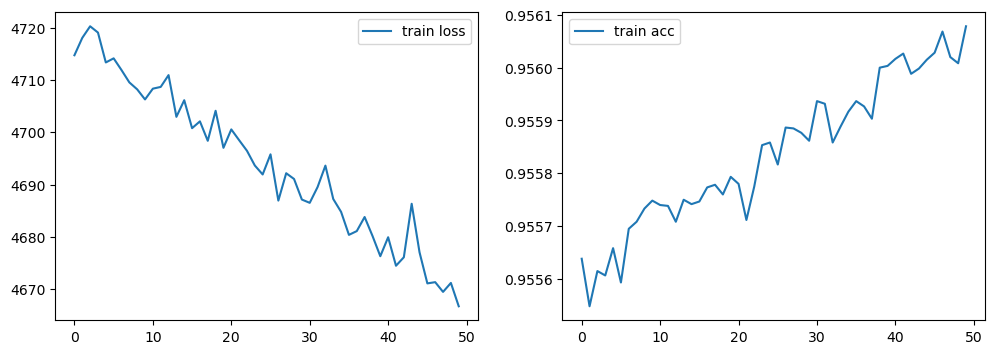

In [11]:
reseau1.afficher_courbe()

In [8]:
v1 = y.flatten().round()
v2 = reseau1.predict(X).flatten().round()
accuracy_score(v1,v2) #efficasité avec base de donné de l'entrainement
accuracy_score(y_test.flatten().round(), reseau1.predict(X_test.T.reshape((784, -1))).flatten().round()) #efficasité avec base de donné exterieure

0.974

C:\Users\Utilisateur local\AppData\Local\Temp\ipykernel_9284\409559921.py:21: RuntimeWarning: overflow encountered in exp
  activations['A' + str(c)] = 1/ ( 1+ np.exp(-Z)) #1. * (Z > 0)


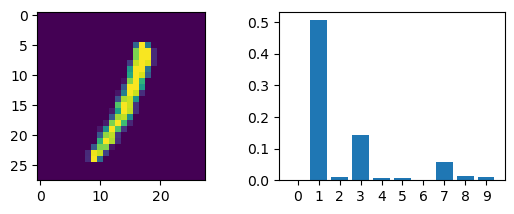

{'orange': 13, 'rouge': 5}

In [7]:
import time
def afficher_graph_et_image(index):
    compte = {'orange': 0,
              'rouge' : 0}
    m = len(index)
    for i in index:
        clear_output(wait=True)
        a0 = X.T[i].reshape(28,28)
        a1 = a0.reshape(784,1)
        a2 = np.argmax(y.T[i])
        g = reseau1.predict(a1)
        if np.argmax(g) != a2:
            g1 = [k for k in range(10) if g[k] == max([g[j] for j in range(10) if j != np.argmax(g)])]
            if g1 == a2:
                plt.figure(facecolor='orange')
                compte['orange'] += 1
            else:
                plt.figure(facecolor='red')
                compte['rouge'] += 1
        plt.subplot(2,2,1)
        plt.imshow(a0)
        plt.subplot(2,2,2)
        plt.bar([str(k) for k in range(10)], [float(li) for li in list(g)])
        plt.show()
        time.sleep(0.1)
    return compte
afficher_graph_et_image(range(100))

In [2]:
#####permet de reinitialiser les records du jeu
import pickle
record = {
    None : {None : 0}, #si aucun jeu n'est selectionner 
    True : {
        0.5: 0, 
        1:   0, 
        2:   0,
        },
    False : {
        10: float('inf'), 
        20:  float('inf'), 
        30:  float('inf'), 
        40:  float('inf'), 
        50:  float('inf'),
        },
}
f = open('parametres/record.pkl',"wb")
pickle.dump(record,f)
f.close()

In [8]:
echo "salut"

SyntaxError: invalid syntax (2773556058.py, line 1)

salut <br>
salut

In [2]:
a = 0

In [5]:
print(a)

1


In [4]:
a = 1